In [205]:
!pip install pytorchts -q

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.base.transform import BoxCox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

import warnings
warnings.filterwarnings('ignore', category=InterpolationWarning)

from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import MultivariateEvaluator

import torch
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer
device = 'cuda'

In [207]:
aus_retail = pd.read_csv('https://raw.githubusercontent.com/vpozdnyakov/probabilistic_forecasting/main/datasets/aus_retail.csv',  index_col=0)
aus_retail.index = pd.to_datetime(aus_retail.index)
aus_retail.head()

,A3349335T,A3349627V,A3349338X,A3349398A,A3349468W,A3349336V,A3349337W,A3349397X,A3349399C,A3349874C,A3349871W,A3349790V,A3349556W,A3349791W,A3349401C,A3349873A,A3349872X,A3349709X,A3349792X,A3349789K,A3349555V,A3349565X,A3349414R,A3349799R,A3349642T,A3349413L,A3349564W,A3349416V,A3349643V,A3349483V,A3349722T,A3349727C,A3349641R,A3349639C,A3349415T,A3349349F,A3349563V,A3349350R,A3349640L,A3349566A,...,A3349605F,A3349688X,A3349456L,A3349774V,A3349848X,A3349457R,A3349851L,A3349604C,A3349608L,A3349609R,A3349773T,A3349852R,A3349775W,A3349776X,A3349607K,A3349849A,A3349850K,A3349606J,A3349932R,A3349862V,A3349462J,A3349463K,A3349334R,A3349863W,A3349781T,A3349861T,A3349626T,A3349617R,A3349546T,A3349787F,A3349333L,A3349860R,A3349464L,A3349389X,A3349461F,A3349788J,A3349547V,A3349388W,A3349870V,A3349396W
Series ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982-04-01,303.1,41.7,63.9,408.7,65.8,91.8,53.6,211.3,94.0,32.7,126.7,178.3,50.4,22.2,43.0,62.4,178.0,61.8,85.4,147.2,1250.2,257.9,17.3,34.9,310.2,58.2,55.8,59.1,173.1,93.6,26.3,119.9,104.2,42.2,15.6,31.6,34.4,123.7,36.4,48.7,...,1.6,15.5,2.7,4.4,2.6,9.7,3.7,2.2,5.9,10.3,2.3,1.1,2.5,2.2,8.1,4.4,3.2,7.6,57.1,933.4,79.6,149.6,1162.6,200.3,243.4,148.6,592.3,268.5,91.4,359.9,460.1,135.1,64.9,125.6,153.5,479.1,146.3,196.1,342.4,3396.4
1982-05-01,297.8,43.1,64.0,404.9,65.8,102.6,55.4,223.8,105.7,35.6,141.3,202.8,49.9,23.1,45.3,63.1,181.5,60.8,84.8,145.6,1300.0,257.4,18.1,34.6,310.1,62.0,58.4,59.2,179.5,95.3,27.1,122.5,110.2,42.1,15.8,31.5,34.4,123.9,36.2,48.9,...,1.6,15.1,3.0,4.9,3.3,11.1,3.8,2.1,5.9,10.6,2.5,1.0,2.5,2.0,8.0,3.4,3.3,6.7,57.3,920.5,80.8,149.7,1150.9,210.3,268.3,151.0,629.6,289.8,96.8,386.6,502.6,134.9,67.7,128.7,154.8,486.1,145.5,196.6,342.1,3497.9
1982-06-01,298.0,40.3,62.7,401.0,62.3,105.0,48.4,215.7,95.1,32.5,127.6,176.3,48.0,22.8,43.7,59.6,174.1,58.7,80.7,139.4,1234.2,261.2,18.1,34.6,313.9,53.8,53.7,59.8,167.3,85.2,24.3,109.6,96.7,38.5,15.2,29.6,33.5,116.8,35.7,47.1,...,1.7,15.5,2.5,4.8,2.7,9.9,3.2,2.0,5.1,9.9,2.3,1.0,2.5,2.0,7.8,3.6,3.5,7.1,55.3,933.6,77.3,149.0,1160.0,198.7,266.1,142.6,607.4,261.9,88.6,350.5,443.8,128.2,65.5,125.0,148.8,467.5,140.2,188.5,328.7,3357.8
1982-07-01,307.9,40.9,65.6,414.4,68.2,106.0,52.1,226.3,95.3,33.5,128.8,172.6,48.6,23.2,46.5,61.9,180.2,60.3,82.4,142.7,1265.0,266.1,18.9,35.2,320.2,57.9,56.9,59.8,174.5,91.6,25.6,117.2,104.6,38.9,15.2,35.2,33.4,122.7,34.6,47.5,...,1.6,16.1,2.8,5.1,2.4,10.2,3.4,2.1,5.4,8.8,2.6,1.1,2.6,2.0,8.3,4.0,3.5,7.5,56.3,972.6,80.4,153.5,1206.4,208.7,273.5,150.1,632.4,267.2,92.1,359.3,459.1,129.9,68.5,136.6,156.1,491.1,146.5,192.0,338.5,3486.8
1982-08-01,299.2,42.1,62.6,403.8,66.0,96.9,54.2,217.1,82.8,29.4,112.3,169.6,51.3,21.4,44.8,60.7,178.1,56.1,80.7,136.8,1217.6,247.2,19.0,33.8,300.1,59.2,56.7,62.2,178.1,85.2,23.5,108.7,92.5,39.5,14.5,34.7,33.2,122.0,32.5,49.3,...,1.6,15.8,2.8,4.6,2.7,10.1,3.1,2.0,5.0,8.8,2.6,0.9,2.8,2.0,8.4,3.6,3.7,7.3,55.4,923.5,81.6,147.3,1152.5,206.2,262.7,153.7,622.6,241.5,83.7,325.2,438.4,133.0,65.2,134.7,152.8,485.7,138.8,192.7,331.5,3355.9


In [208]:
train_bound = pd.Timestamp('2016-02-01')
test_bound = pd.Timestamp('2011-02-01')

In [209]:
train = aus_retail[aus_retail.index <= train_bound].iloc[:, :4]
test = aus_retail[aus_retail.index > train_bound].iloc[:, :4]
train.shape, test.shape

((407, 4), (60, 4))

In [210]:
start = train.index[0]
freq = 'M'
train_ds = ListDataset(
    [{'target': ts, 'start': start} for ts in train.values.T],
    freq=freq)

start = train_bound
test_ds = ListDataset(
    [{'target': ts, 'start': start} for ts in train.values[-60:].T],
    freq=freq)

In [211]:
train_grouper = MultivariateGrouper(
    max_target_dim=4)
test_grouper = MultivariateGrouper(
    max_target_dim=4)

dataset_train = train_grouper(train_ds)
dataset_test = test_grouper(test_ds)

In [212]:
evaluator = MultivariateEvaluator(
    quantiles=[0.025, 0.5, 0.975],
    target_agg_funcs={'sum': np.sum})

In [213]:
estimator = TransformerTempFlowEstimator(
    input_size=10,
    d_model=16,
    num_heads=4,
    target_dim=4,
    prediction_length=60,
    context_length=60,
    flow_type='MAF',
    dequantize=True,
    freq='M',
    lags_seq=[12],
    trainer=Trainer(
        device=device,
        epochs=8,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64))

In [214]:
predictor = estimator.train(dataset_train)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)
99it [00:05, 19.49it/s, avg_epoch_loss=-4.17, epoch=0]
99it [00:05, 19.05it/s, avg_epoch_loss=-5.72, epoch=1]
97it [00:05, 19.15it/s, avg_epoch_loss=-6.71, epoch=2]
98it [00:04, 20.05it/s, avg_epoch_loss=-7.98, epoch=3]
97it [00:04, 19.67it/s, avg_epoch_loss=-8.81, epoch=4]
98it [00:04, 19.66it/s, avg_epoch_loss=-9.44, epoch=5]
97it [00:04, 19.48it/s, avg_epoch_loss=-9.75, epoch=6]
99it [00:05, 19.67it/s, avg_epoch_loss=-9.95, epoch=7]


In [215]:
forecasts = list(predictor.predict(dataset_test, num_samples=1000))
forecast = forecasts[0].samples

/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)


In [216]:
proba_forecast = np.quantile(forecast, q=[0.025, 0.5, 0.975], axis=0, )
lower_forecast = proba_forecast[0]
point_forecast = proba_forecast[1]
upper_forecast = proba_forecast[2]

In [217]:
pred = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index[-60:])
lower = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index[-60:])
upper = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index[-60:])

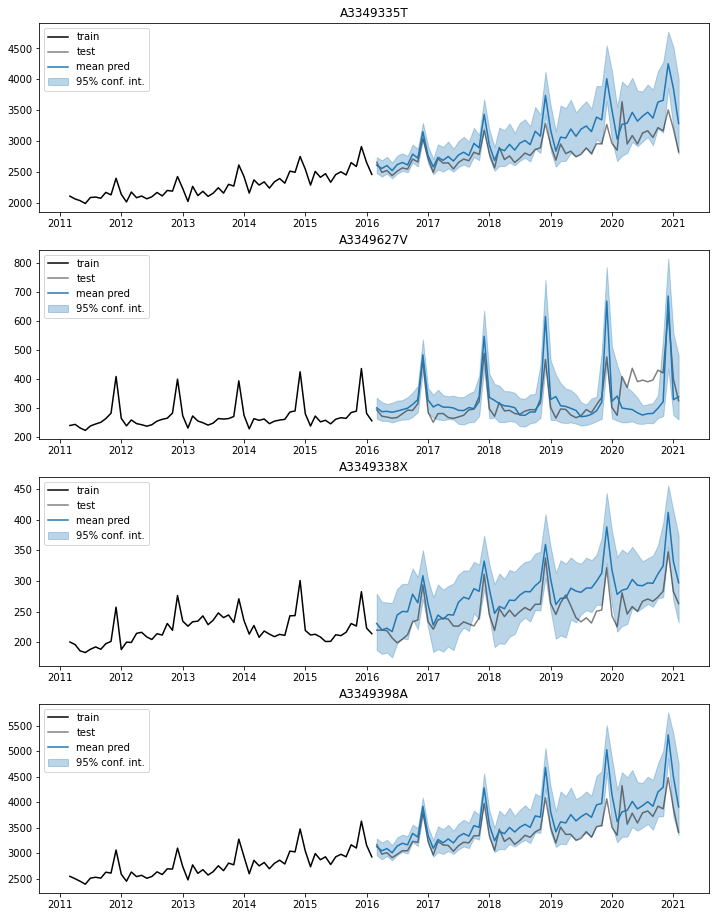

In [218]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col].iloc[-60:], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)